# Prática 02 - k-NN e Avaliação de Classificadores

In [250]:
# Celula de definicao das libraries/dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
# Importe outras libraries que vc ira usar aqui!
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score
import plotly.express as px

# Lembre que o dataset da prática 1 é o do link abaixo
titanic = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')

In [251]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Initially we can drop Cabin, PassengerId, Name, Ticket, Embarked, since these conceptually add little to no value to our classification task.
Age has a lot of null values, so we should deal with this. First let's take a look at how age is distributed to know what to do.

In [252]:
px.histogram(titanic, 'Age', nbins=80)

In [253]:
px.box(titanic, 'Age')

In [254]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The age distribution doesn't appear to follow a Normal Distribution, so the mean might not be very representative of the data, plus there is the presence of high outliers, which pull the mean up. We see, however, that the median, or 50% quantile is very close to the mean, and closer to where most of the data is concentrated so we may use it to fill null values.

In [255]:
def get_df_pipeline1(df: pd.DataFrame):
  df = df.copy()

  median_age = titanic['Age'].median()
  df['Age'].fillna(median_age, inplace=True)

  df.drop(['Cabin', 'PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1, inplace=True)

  # encoding
  le = preprocessing.LabelEncoder()
  df['Sex_Encoded'] = le.fit_transform(df['Sex'])
  df.drop(['Sex'], axis=1, inplace=True)

  return df

In [256]:
df = get_df_pipeline1(titanic)

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_59436/4227628289.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Sex_Encoded  891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [258]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Encoded
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.647587
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.477990
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


We observe the standard deviation reduced. This happens when we introduce many new values close to the mean, so the data is less scattered around the mean.

**Fique a vontade de usar a função [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) do Sklearn também =)**

## k-NN




### Preprocessing

In [259]:
def preprocess_titanic_knn(df: pd.DataFrame):
    df = df.copy()
    y = df["Survived"]
    X = df
    X.drop("Survived", axis=1, inplace=True)

    scaler = preprocessing.StandardScaler()
    scaled = scaler.fit_transform(X)
    X = pd.DataFrame(scaled, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    return X_train, X_test, y_train, y_test

In [260]:
X_train, X_test, y_train, y_test = preprocess_titanic_knn(df)

### Baseline Model, testing values for K, no CV

In [261]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.4)  # for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

In [262]:
def print_metrics(y_test, y_pred):
    print('PRED SCORES')
    print('Accuracy Score - [(tp + tn) / (tp + tn + fp + fn)]:', accuracy_score(y_test, y_pred))  
    print('F1 Score - [2 * (precision * recall / (precision + recall))] :', f1_score(y_test, y_pred)) 
    print('Precision - [tp / (tp + fp)]:', precision_score(y_test, y_pred)) 
    print('Recall - [tp / (tp + fn)]:', recall_score(y_test, y_pred))

In [263]:
k_values = [i for i in range (1,31, 2)]
accuracies = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append([accuracy, k, y_test, y_pred])

max = [-1, 0]
for i in accuracies:
  if i[0] > max[0]:
    max = i

print(max[0], max[1])

0.8134328358208955 5


Observe that the current best value for K is 5, with an accuracy of 81.3432%

In [264]:
acc = [i[0] for i in accuracies]

fig = px.line(x=k_values, y=acc, labels={'x': 'Values for K', 'y': 'Prediction Accuracy'})
fig.update_xaxes(tickmode='array', tickvals=k_values)
fig.show()

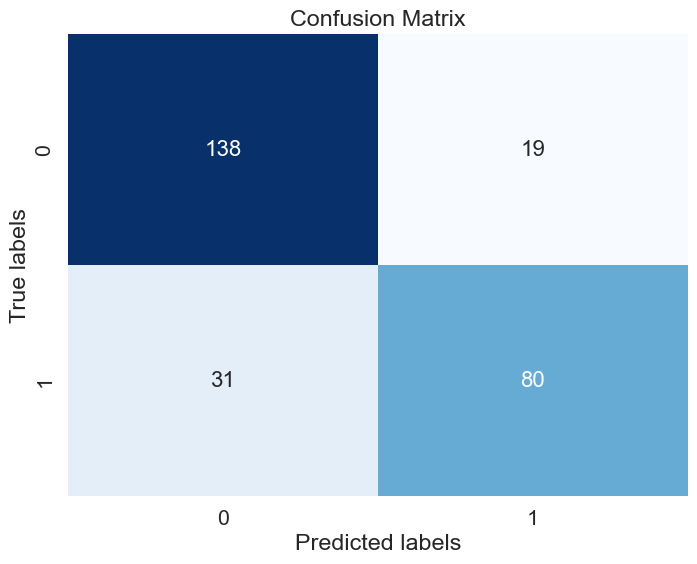

In [265]:
y_test, y_pred = max[2], max[3]
plot_confusion_matrix(y_test, y_pred)

In [266]:
print_metrics(y_test, y_pred)

PRED SCORES
Accuracy Score - [(tp + tn) / (tp + tn + fp + fn)]: 0.8134328358208955
F1 Score - [2 * (precision * recall / (precision + recall))] : 0.7619047619047619
Precision - [tp / (tp + fp)]: 0.8080808080808081
Recall - [tp / (tp + fn)]: 0.7207207207207207


### Using CV to find best K

In [267]:
k_values_cv = [i for i in range (1,31, 2)]
accuracies_cv = []

X_train_cv, X_test_cv, y_train_cv, y_test_cv = preprocess_titanic_knn(df)

for k in k_values_cv:
    classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(classifier, X_train_cv, y_train_cv, scoring='accuracy', cv=5)

    # accuracy = accuracy_score(y_test, y_pred)
    accuracy = scores.mean()
    accuracies_cv.append([accuracy, k, y_test_cv])

max_cv = [-1, 0]
for i in accuracies_cv:
  if i[0] > max[0]:
    max_cv = i

print(max_cv[0], max_cv[1])
classifier = KNeighborsClassifier(n_neighbors=max_cv[1])
classifier.fit(X_train_cv, y_train_cv)
y_pred_cv = classifier.predict(X_test_cv)
accuracy = accuracy_score(y_test_cv, y_pred_cv)
print(f"test score: {accuracy}")

0.820258064516129 25
test score: 0.7873134328358209


In [268]:
accs = [i[0] for i in accuracies_cv]
fig = px.line(x=k_values_cv, y=accs, labels={'x': 'Values for K', 'y': 'Prediction Accuracy'})
fig.update_xaxes(tickmode='array', tickvals=k_values)
fig.show()

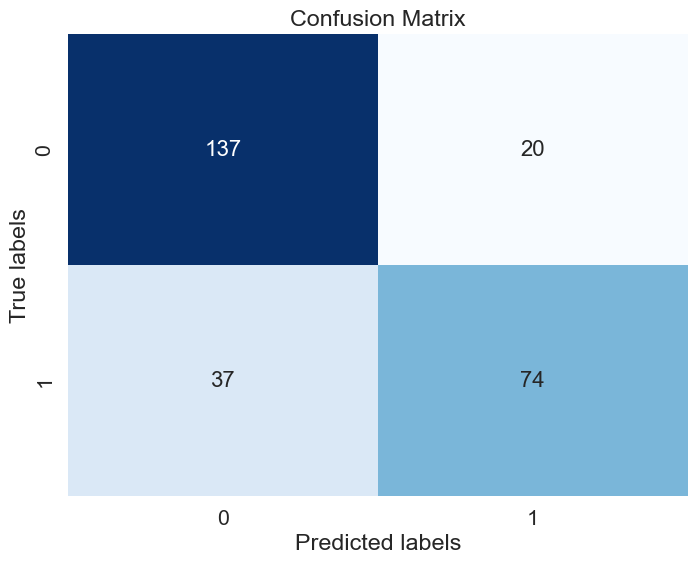

In [269]:
plot_confusion_matrix(y_test_cv, y_pred_cv)

In [270]:
print_metrics(y_test_cv, y_pred_cv)

PRED SCORES
Accuracy Score - [(tp + tn) / (tp + tn + fp + fn)]: 0.7873134328358209
F1 Score - [2 * (precision * recall / (precision + recall))] : 0.7219512195121951
Precision - [tp / (tp + fp)]: 0.7872340425531915
Recall - [tp / (tp + fn)]: 0.6666666666666666


Using K-Fold Cross Validation to find optimal K value may not be justifiable for this dataset. It does not have enough data points to justify this, since just testing multiple values for K using a common holdout on this specific entire dataset is not computationally expensive at all for modern computers. Using K-Fold, and thus reducing the data points we fit each time, finds a value for K that isn't optimal for the whole population, reducing the model's performance.

### Using GridSearch to find optimal hyperparams

In [271]:
gs_classifier = KNeighborsClassifier(algorithm='auto')
parameters = {
    'n_neighbors': k_values,
    'leaf_size': [20, 30, 40],
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'chebyshev'],
}
                   
# with GridSearch
knn_gscv = GridSearchCV(
    estimator=gs_classifier,
    param_grid=parameters,
    scoring = 'accuracy',
    cv = 5
)

In [272]:
X_train_gs, X_test_gs, y_train_gs, y_test_gs = preprocess_titanic_knn(df)
best_model = knn_gscv.fit(X_train_gs, y_train_gs)
y_pred_gs = best_model.best_estimator_.predict(X_test_gs)

print(f"Grid Search training acc: {best_model.best_score_}")
print(best_model.best_params_)

Grid Search training acc: 0.8218580645161291
{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 23, 'p': 2, 'weights': 'uniform'}


In [273]:
print_metrics(y_test_gs, y_pred_gs)

PRED SCORES
Accuracy Score - [(tp + tn) / (tp + tn + fp + fn)]: 0.7947761194029851
F1 Score - [2 * (precision * recall / (precision + recall))] : 0.729064039408867
Precision - [tp / (tp + fp)]: 0.8043478260869565
Recall - [tp / (tp + fn)]: 0.6666666666666666


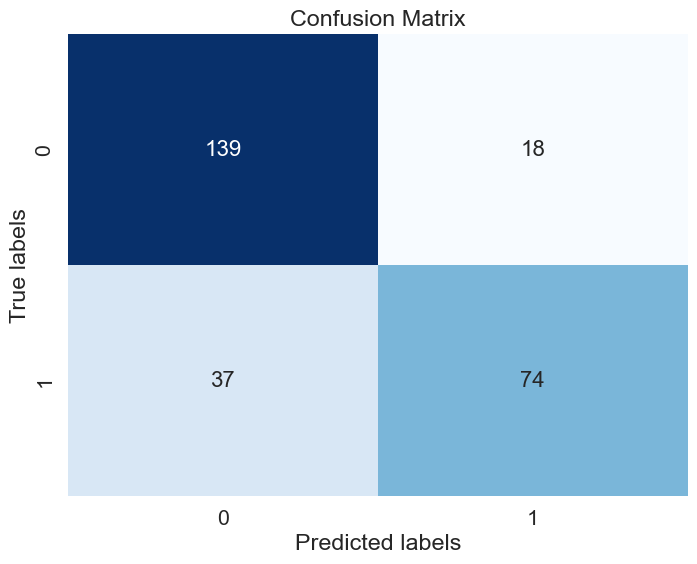

In [274]:
plot_confusion_matrix(y_test_gs, y_pred_gs)

Using GridSearchCV, due to the K-Fold CV, falls on the same pitfall as just using CV with the default model. So far, the baseline KNN model has the best performance.

## SVM